In [229]:
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import GridSearchCV
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt
import sklearn.metrics as mt
from dataAnalyzer import *
from private_tool import *
from dataHandler import *
import sklearn.svm as svm
from numpy import array
import pandas as pd
import warnings

In [230]:
warnings.filterwarnings('ignore')

In [231]:
experimentNum = 9
experimentIdx = 4
Experiments = [MotorImageryDataset(parentDirectory(dir=currDir, separator="\\", n=1)+'/bcicompetitionIV2a/A0'+str(i+1)+'T.npz') for i in range(experimentNum)]

In [232]:
channels = [i for i in range(25)]
samplingRate = 250 #Hz
trialsByClasses = array([i.get_trials_by_classes(channels=channels) for i in Experiments])

In [233]:
len(trialsByClasses[0]["left"][0])

69

In [234]:
channelNum = len(channels)
m = len(trialsByClasses[0]["left"])
channelNum, m

(25, 25)

In [235]:
bandpassedTrialsByClasses = [{i:[[] for _ in range(channelNum)] for i in j.mi_types.values()} for j in Experiments]
for k in range(experimentNum):
    for key in trialsByClasses[k].keys():
        for i in range(channelNum):
            bandpassedTrialsByClasses[k][key][i] = np.array([bandpass_filter(data=trialsByClasses[k][key][i][j], 
                                                                sample_rate=samplingRate, 
                                                                cutoff_low=5, 
                                                                cutoff_high=50)\
                                                for j in range(len(trialsByClasses[k][key][i]))])

In [236]:
# bandpassedTrialsByClasses[2]["left"][2].shape

In [237]:
# 현재 상태는 experiment - class - channel - trial - signal
# class - experiment - trial - channel - signal로 수정하자
bandpassedTrialsByClasses = {key:array([[bandpassedTrialsByClasses[i][key][j] for j in range(channelNum)] for i in range(experimentNum)]) for key in Experiments[0].mi_types.values()}
# bandpassedTrialsByClasses["left"][8][0].shape
# i: experiment
# j: trial

In [238]:
minTrialsNum = sorted([len(bandpassedTrialsByClasses["left"][i][0]) for i in range(experimentNum)])[0]
bandpassedTrialsByClasses = {i:[bandpassedTrialsByClasses[i][j] for j in range(experimentNum)] for i in Experiments[0].mi_types.values()}

In [239]:
left_csp_filter = CSP_filter(len(bandpassedTrialsByClasses["left"][experimentIdx]), bandpassedTrialsByClasses["left"][experimentIdx])
right_csp_filter = CSP_filter(len(bandpassedTrialsByClasses["right"][experimentIdx]), bandpassedTrialsByClasses["right"][experimentIdx])
tongue_csp_filter = CSP_filter(len(bandpassedTrialsByClasses["tongue"][experimentIdx]), bandpassedTrialsByClasses["tongue"][experimentIdx])
foot_csp_filter = CSP_filter(len(bandpassedTrialsByClasses["foot"][experimentIdx]), bandpassedTrialsByClasses["foot"][experimentIdx])

In [240]:
bandpassedTrials = {i:[] for i in Experiments[0].mi_types.values()}
for i in Experiments[0].mi_types.values():
    for j in range(len(bandpassedTrialsByClasses)):
        bandpassedTrials[i]

In [241]:
# CSP_passed_left_data = np.array([[bandpassedTrialsByClasses[i][j].T@left_csp_filter for j in range(minTrialsNum)] for i in range(experimentNum)])
CSP_passed_left_data = [j.T@left_csp_filter for j in bandpassedTrialsByClasses["left"][experimentIdx]]
CSP_passed_right_data = [j.T@right_csp_filter for j in bandpassedTrialsByClasses["right"][experimentIdx]]
CSP_passed_tongue_data = [j.T@tongue_csp_filter for j in bandpassedTrialsByClasses["tongue"][experimentIdx]]
CSP_passed_foot_data = [j.T@foot_csp_filter for j in bandpassedTrialsByClasses["foot"][experimentIdx]]

In [242]:
len(CSP_passed_left_data)

25

In [243]:
# bandpassedTrialsByClasses["right"][0]["right"][0]

In [244]:
print(array(CSP_passed_left_data).shape)
CSP_passed_left_data = [np.array([j.T for j in i]).T for i in CSP_passed_left_data]
CSP_passed_right_data = [np.array([j.T for j in i]).T for i in CSP_passed_right_data]
CSP_passed_tongue_data = [np.array([j.T for j in i]).T for i in CSP_passed_tongue_data]
CSP_passed_foot_data = [np.array([j.T for j in i]).T for i in CSP_passed_foot_data]

(25, 1875, 63)


In [245]:
array(CSP_passed_left_data).shape

(25, 63, 1875)

In [246]:
CSP_passed_left_data = array([i.T for i in array(CSP_passed_left_data).T]).T
CSP_passed_right_data = array([i.T for i in array(CSP_passed_right_data).T]).T
CSP_passed_tongue_data = array([i.T for i in array(CSP_passed_tongue_data).T]).T
CSP_passed_foot_data = array([i.T for i in array(CSP_passed_foot_data).T]).T

In [247]:
from math import log
m = 3
print(len(CSP_passed_left_data))

leftVar = np.array([np.array([np.var(CSP_passed_left_data[i][j]) for j in range(channelNum)]) for i in range(minTrialsNum)])
rightVar = np.array([np.array([np.var(CSP_passed_right_data[i][j]) for j in range(channelNum)]) for i in range(minTrialsNum)])
tongueVar = np.array([np.array([np.var(CSP_passed_tongue_data[i][j]) for j in range(channelNum)]) for i in range(minTrialsNum)])
footVar = np.array([np.array([np.var(CSP_passed_foot_data[i][j]) for j in range(channelNum)]) for i in range(minTrialsNum)])


leftVarRatio = np.array([np.array([log(leftVar[i][j-m]/sum(leftVar[i])) for j in range(m*2)]) for i in range(minTrialsNum)])
rightVarRatio = np.array([np.array([log(rightVar[i][j-m]/sum(rightVar[i])) for j in range(m*2)]) for i in range(minTrialsNum)])
tongueVarRatio = np.array([np.array([log(tongueVar[i][j-m]/sum(tongueVar[i])) for j in range(m*2)]) for i in range(minTrialsNum)])
footVarRatio = np.array([np.array([log(footVar[i][j-m]/sum(footVar[i])) for j in range(m*2)]) for i in range(minTrialsNum)])

63


In [248]:
leftVarRatioDF = pd.DataFrame(leftVarRatio)
rightVarRatioDF = pd.DataFrame(rightVarRatio)
tongueVarRatioDF = pd.DataFrame(tongueVarRatio)
footVarRatioDF = pd.DataFrame(footVarRatio)

labelDF = pd.DataFrame([0]*minTrialsNum + [1]*minTrialsNum + [2]*minTrialsNum + [3]*minTrialsNum)

In [249]:
VarRatioDF = pd.concat([leftVarRatioDF, rightVarRatioDF, tongueVarRatioDF, footVarRatioDF], axis=0)
VarRatioDF = VarRatioDF.reset_index()
VarRatioDF = pd.concat([VarRatioDF, labelDF], axis=1).iloc[:,1:]
VarRatioDF.columns = [f"{n}" for n in range(m*2)] + ["target"]
VarRatioDF

,0,1,2,3,4,5,target
0,-3.421152,-2.536799,-2.939862,-3.019234,-3.180999,-3.119417,0
1,-3.818872,-2.243407,-3.172515,-2.942016,-3.184317,-3.127724,0
2,-3.777463,-2.503529,-3.023081,-2.984156,-3.243622,-3.183651,0
3,-3.679155,-2.497401,-3.114380,-2.946782,-3.204353,-3.110865,0
4,-3.781104,-2.676327,-3.115687,-3.049064,-3.177323,-3.163738,0
...,...,...,...,...,...,...,...
207,-3.539019,-2.362719,-3.387453,-2.983615,-3.104612,-3.104596,3
208,-3.905729,-2.298080,-3.279209,-3.054010,-3.186066,-3.142487,3
209,-3.704005,-2.473664,-3.147647,-3.064016,-3.236888,-3.170324,3
210,-3.822086,-2.510794,-3.158161,-2.936987,-3.234727,-3.091373,3


In [250]:

x = VarRatioDF.drop(['target'], axis=1).values 
y = VarRatioDF['target'].values # 종속변인 추출
x = StandardScaler().fit_transform(x)
pd.DataFrame(x)

,0,1,2,3,4,5
0,2.902428,-0.192234,2.567565,-0.543220,0.523775,0.326085
1,-0.496732,1.632759,0.584366,0.648213,0.460382,0.140923
2,-0.142826,0.014716,1.858182,-0.001993,-0.672643,-1.105685
3,0.697374,0.052837,1.079926,0.574671,0.077594,0.516702
4,-0.173946,-1.060140,1.068779,-1.003492,0.594014,-0.661828
...,...,...,...,...,...,...
207,1.895065,0.890601,-1.247832,0.006367,1.983154,0.656430
208,-1.239072,1.292676,-0.325130,-1.079805,0.426968,-0.188153
209,0.484987,0.200490,0.796349,-1.234183,-0.543982,-0.808622
210,-0.524204,-0.030470,0.706721,0.725805,-0.502690,0.951162


In [251]:
n_componunts = 4
PCA = PrincipalComponuntAnalysis(n_componunts=n_componunts, data=x)
principalDF = PCA.principalDf

In [252]:
sum(PCA.explained_variance_ratio_())

0.9099736239645932

In [253]:
pd.concat([principalDF, labelDF], axis=1)

,principal component1,principal component2,principal component3,principal component4,0
0,1.490455,-2.148612,-2.909137,0.203409,0
1,-0.333861,-1.336704,1.052194,-0.265775,0
2,1.670471,-0.471790,-0.124526,-1.319990,0
3,0.037148,-1.139292,-0.746532,-0.550911,0
4,0.720349,0.709007,-1.204643,-0.436573,0
...,...,...,...,...,...
207,-1.298304,-1.321764,-0.714718,2.504540,3
208,-0.034200,0.479183,1.278496,0.569434,3
209,1.692759,0.123022,-0.313137,0.260882,3
210,-0.456115,-0.365706,0.072503,-1.221329,3


In [254]:
# import matplotlib.pyplot as plt

# fig = plt.figure(figsize = (8, 8))
# ax = fig.add_subplot(1, 1, 1)
# ax.set_xlabel('Principal Component 1', fontsize = 15)
# ax.set_ylabel('Principal Component 2', fontsize = 15)
# ax.set_title('1 component PCA', fontsize=20)

# targets = [0, 1, 2, 3]
# colors = ['r', 'g', 'b', 'purple']
# for target, color in zip(targets,colors):
#     indicesToKeep = VarRatioDF['target'] == target
#     ax.scatter(principalDf.loc[indicesToKeep, 'principal component1']
#                , principalDf.loc[indicesToKeep, 'principal component2']
#                , c = color
#                , s = 50, alpha=0.5)
# ax.legend(targets)
# ax.grid()

In [255]:
# last_data = pd.concat([principalDf.loc[:, 'principal component1'], 
#     principalDf.loc[:, 'principal component2'], 
#     labelDF], axis=1)

# last_data.columns = ['principal component1', 'principal component2', 'label']           

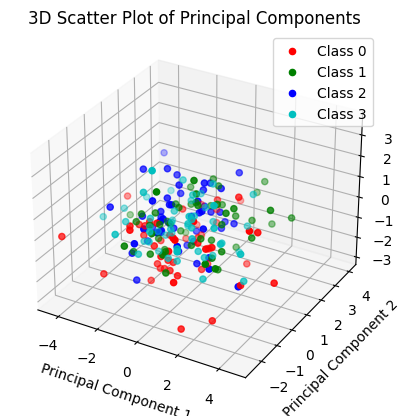

In [256]:


# 데이터를 DataFrame으로 생성
df = pd.concat([principalDF, labelDF], axis=1)
df.columns = [f"principal component{i+1}" for i in range(n_componunts)]+["label"]

# # 3D scatter plot 그리기
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# # 클래스별로 색상을 다르게 설정
# colors = ['r', 'g', 'b', 'c']
# for i in range(4):  # 클래스 개수에 맞게 범위 설정
#     subset = df[df['label'] == i]
#     ax.scatter(subset['principal component1'], subset['principal component2'], subset['principal component3'], c=colors[i], label=f'Class {i}')

# ax.set_xlabel('Principal Component 1')
# ax.set_ylabel('Principal Component 2')
# ax.set_zlabel('Principal Component 3')
# ax.set_title('3D Scatter Plot of Principal Components')
# ax.legend()
# plt.show()

In [291]:
LDA_DF = pd.concat([pd.DataFrame(LDATransform(principalDF, labelDF, 3, "eigen")), labelDF], axis=1)

In [292]:
import numpy as np
LDA_DF.columns = [f"axis{i+1}" for i in range(3)] + ["label"]

In [293]:
scaler = StandardScaler()
scaler.fit(LDA_DF.loc[:, :"axis3"])
LDA_DF_Scaled = pd.concat([pd.DataFrame(scaler.transform(LDA_DF.loc[:, :"axis3"])), labelDF], axis=1)
LDA_DF_Scaled.columns = [f"axis{i+1}" for i in range(3)] + ["label"]
LDA_DF_Scaled

,axis1,axis2,axis3,label
0,-2.783931,-1.596928,-0.682753,0
1,-0.458026,0.226676,0.353297,0
2,-0.873934,0.816592,-1.635416,0
3,-0.959289,-0.602853,-0.756177,0
4,-0.106950,-0.163974,-1.158787,0
...,...,...,...,...
207,-0.734069,-1.758494,2.946782,3
208,0.672140,0.775424,1.097601,3
209,-0.606851,0.582220,0.032804,3
210,-0.012656,-0.046720,-1.300611,3


In [294]:
np.save("./dataframe", LDA_DF_Scaled)

In [297]:
# 2
# 테스트하고자 하는 파라미터 값들을 사전타입으로 정의
svm_clf = svm.SVC(kernel = 'rbf',random_state=100)
parameters = {
    'C': [0.01, 0.1, 1, 5, 10, 25, 50, 100],
    'gamma': [0.001, 0.01, 0.1, 1, 10, 25, 50, 100],
}

grid_svm = GridSearchCV(svm_clf,
    param_grid = parameters, cv = 2, n_jobs=-1, refit=True)

grid_svm.fit(LDA_DF_Scaled.loc[:, :"axis3"], labelDF)

result = pd.DataFrame(grid_svm.cv_results_['params'])
result['mean_test_score'] = grid_svm.cv_results_['mean_test_score']
print()
print(round(result.sort_values(by='mean_test_score', ascending=False).iloc[0]["mean_test_score"],3))


0.401


In [296]:
import sklearn.svm as svm
import sklearn.metrics as mt
from sklearn.model_selection import cross_val_score, cross_validate

# SVM, kernel = 'linear'로 선형분리 진행
 
svm_clf =svm.SVC(kernel = 'linear', random_state=100)

# 교차검증

scores = cross_val_score(svm_clf, LDA_DF_Scaled.loc[:, :"axis4"], labelDF, cv = 5)
scores

pd.DataFrame(cross_validate(svm_clf, LDA_DF_Scaled.loc[:, :"axis4"], labelDF, cv =5))

print('교차검증 평균: ', scores.mean())

# SVM, kernel = 'rbf'로 비선형분리 진행
 
svm_clf =svm.SVC(kernel = 'rbf')

# 교차검증

scores = cross_val_score(svm_clf, LDA_DF_Scaled.loc[:, :"axis4"], labelDF, cv = 5)
scores

pd.DataFrame(cross_validate(svm_clf, LDA_DF_Scaled.loc[:, :"axis4"], labelDF, cv =5))

print('교차검증 평균: ', scores.mean())

교차검증 평균:  0.391140642303433
교차검증 평균:  0.3485049833887043
